In [1]:
import pandas as pd
from sklearn import preprocessing, neighbors
from scipy.spatial import distance
import numpy as np
import  matplotlib.pyplot as plt
import networkx as nx
from sklearn.metrics.pairwise import rbf_kernel, cosine_similarity, laplacian_kernel
from sklearn.cluster import KMeans
from scipy.sparse.linalg import eigsh
from scipy.linalg import sqrtm, inv

import seaborn as sns

In [3]:
df = pd.read_csv('/content/Payments.csv')

df

Sender  Receiver  Amount
0         1309      1011  123051
1         1309      1011  118406
2         1309      1011  112456
3         1309      1011  120593
4         1309      1011  166396
...        ...       ...     ...
130530    1344      1390   21739
130531    1914      1390    3374
130532    1914      1390    5186
130533    1914      1390    1559
130534    1914      1390    1997

[130535 rows x 3 columns]

In [4]:
df.max() - df.min()

Sender         1189
Receiver        886
Amount      2122999
dtype: int64

In [5]:
data = df.to_numpy()

## Step 1: Preprocessing dataset

In [6]:
data = preprocessing.normalize(data)
data.shape

(130535, 3)

## Step 2: Compute similarity matrix/ Adjacency matrix, degree matrix and laplacian matrix

In [7]:
import networkx as nx
import pandas as pd
edge_list = pd.read_csv(r'/content/Payments.csv')
edge_list.head()
edge_list = edge_list.applymap(str)
G=nx.from_pandas_edgelist(edge_list, source='Sender', target='Receiver', edge_attr=True, create_using=nx.DiGraph())
G.nodes

NodeView(('1309', '1011', '1259', '1568', '1147', '1393', '1039', '1210', '1005', '1042', '1045', '1018', '1256', '1074', '1668', '1163', '1007', '1034', '1832', '1099', '1488', '1801', '1076', '1944', '1659', '1048', '1205', '1057', '1220', '1032', '1837', '1061', '1222', '1017', '1075', '1023', '2085', '1503', '2088', '1350', '1327', '1276', '1666', '1056', '1748', '1658', '1003', '1228', '1138', '1089', '1002', '1623', '1264', '1875', '1004', '1595', '1090', '1051', '1101', '1079', '1104', '1839', '1747', '1135', '1656', '1500', '1148', '1136', '1172', '1132', '1809', '1774', '1037', '1930', '2184', '1243', '1293', '1990', '1690', '1449', '1310', '1679', '1159', '1335', '1862', '1049', '1105', '1766', '1013', '1541', '1961', '1575', '1189', '1723', '1962', '1084', '1480', '2146', '1405', '1016', '1729', '2166', '2073', '1015', '1344', '1917', '1535', '1077', '1087', '1431', '1080', '1098', '1701', '1009', '1191', '1142', '1081', '1146', '1199', '1754', '1545', '1134', '1517', '1202'

In [8]:
# function to generate random walk sequences of nodes for a particular node
def get_random_walk(node, walk_length):
    # initialization
    random_walk_length = [node]

    #loop over to get the nodes visited in a random walk
    for i in range(walk_length-1):
        # list of neighbors
        neighbors = list(G.neighbors(node))
        # if the same neighbors are present in ranom_walk_length list, then donot add them as new neighbors
        neighbors = list(set(neighbors) - set(random_walk_length))
        if len(neighbors) == 0:
            break
        # pick any one neighbor randomly from the neighbors list
        random_neighbor = random.choice(neighbors)
        # append that random_neighbor to the random_walk_length list
        random_walk_length.append(random_neighbor)
        node = random_neighbor

    return random_walk_length

In [9]:
import random  # Import the random module

def get_random_walk(node, walk_length):
    random_walk_length = [node]  # Initialize the random walk list with the starting node
    while len(random_walk_length) < walk_length:  # Continue until desired walk length is achieved
        # Get the neighbors of the current node
        neighbors = list(G.neighbors(random_walk_length[-1]))
        if len(neighbors) == 0:
            break
        # Pick any one neighbor randomly from the neighbors list
        random_neighbor = random.choice(neighbors)
        # Append that random_neighbor to the random_walk_length list
        random_walk_length.append(random_neighbor)
    return random_walk_length

# Now you can call the get_random_walk function
get_random_walk('1838', 10)


['1838', '1517', '1238', '1508']

In [10]:
get_random_walk('1838', 10)
# calculate random walks for every node in the Graph
all_nodes = list(G.nodes())
number_of_random_walks = 5
random_walks = []
from tqdm import tqdm

for node in tqdm(all_nodes):
    # number of random walks
    for i in range(number_of_random_walks):
        # append the random walk sequence of a node from a specified length
        random_walks.append(get_random_walk(node, 10))
        len(random_walks)
        random_walks[0]
        # train word2vec model
        from gensim.models import Word2Vec
model = Word2Vec(window = 4, sg = 1, hs = 0,
                 negative = 10, # for negative sampling
                 alpha=0.03, min_alpha=0.0007,
    )

model.build_vocab(random_walks, progress_per=2)
model.train(random_walks, total_examples = model.corpus_count, epochs=20, report_delay=1)
# most similar nodes to node '1517'
for node, _ in model.wv.most_similar('1517'):
    print((node, _))

100%|██████████| 799/799 [00:00<00:00, 974.74it/s]


('1838', 0.8289040327072144)
('1124', 0.807015597820282)
('1633', 0.787941575050354)
('1236', 0.782762348651886)
('1428', 0.769314169883728)
('1238', 0.7473264336585999)
('1966', 0.7020033001899719)
('1078', 0.6994749903678894)
('1684', 0.690959632396698)
('1649', 0.686109721660614)


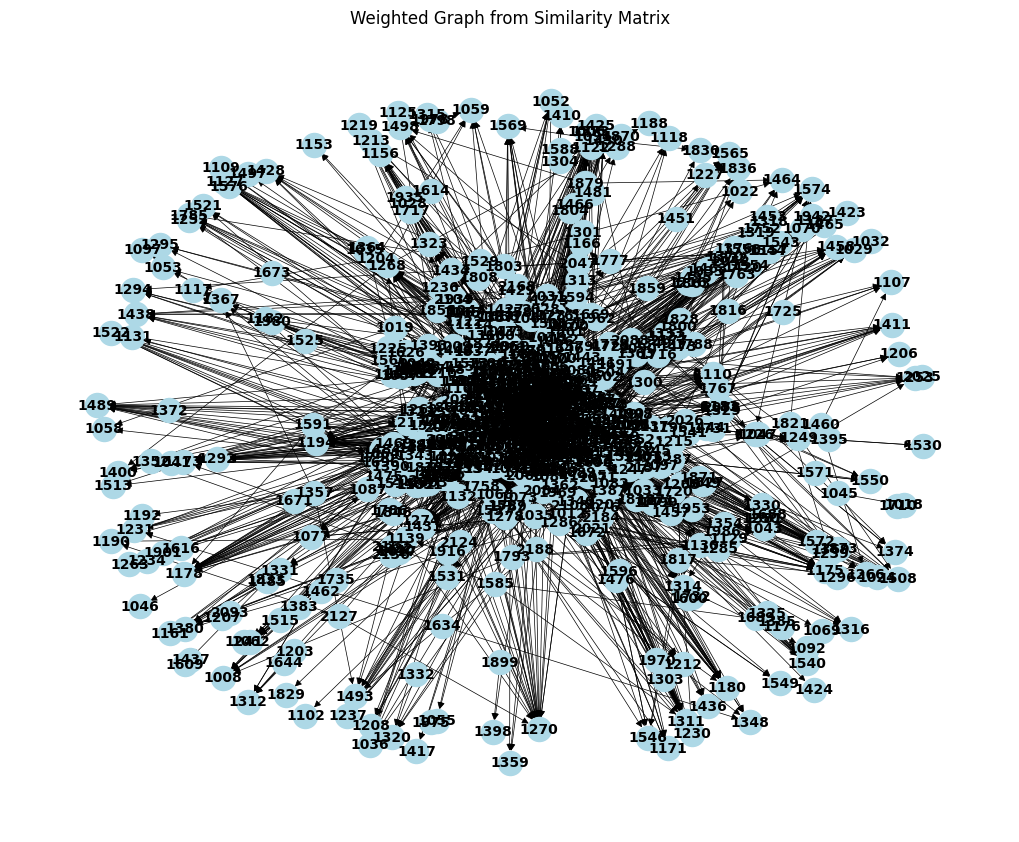

In [19]:
import matplotlib.pyplot as plt

# Draw the graph using matplotlib
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=300, font_size=10, font_weight='bold', width=0.5)
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
plt.title("Weighted Graph from Similarity Matrix")
plt.show()


In [15]:
import pandas as pd
import networkx as nx

# Load data from CSV file
df = pd.read_csv('/content/Payments.csv')

# Create a directed graph
G = nx.from_pandas_edgelist(df, source='Sender', target='Receiver', edge_attr=True, create_using=nx.DiGraph())

# Add features to edges based on CSV data
for sender, receiver, attributes in G.edges(data=True):
    # Get the attributes from the DataFrame based on sender and receiver IDs
    sender_id = sender
    receiver_id = receiver
    amount = df.loc[(df['Sender'] == sender_id) & (df['Receiver'] == receiver_id), 'Amount'].iloc[0]
    # Add transaction amount as a feature to the edge
    G.edges[sender, receiver]['Amount'] = amount

# Now the graph G contains edges with the 'Amount' attribute representing the transaction amount


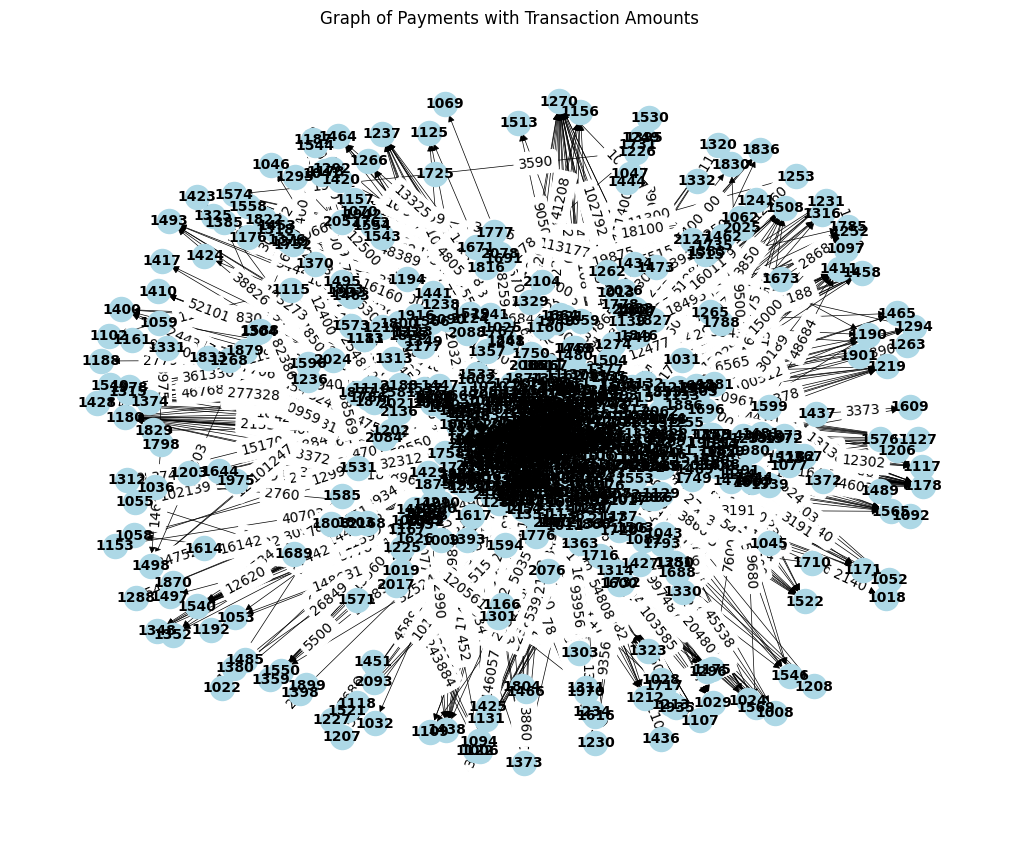

In [16]:
import networkx as nx
import matplotlib.pyplot as plt

# Draw the graph using matplotlib
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=300, font_size=10, font_weight='bold', width=0.5)
labels = nx.get_edge_attributes(G, 'Amount')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
plt.title("Graph of Payments with Transaction Amounts")
plt.show()


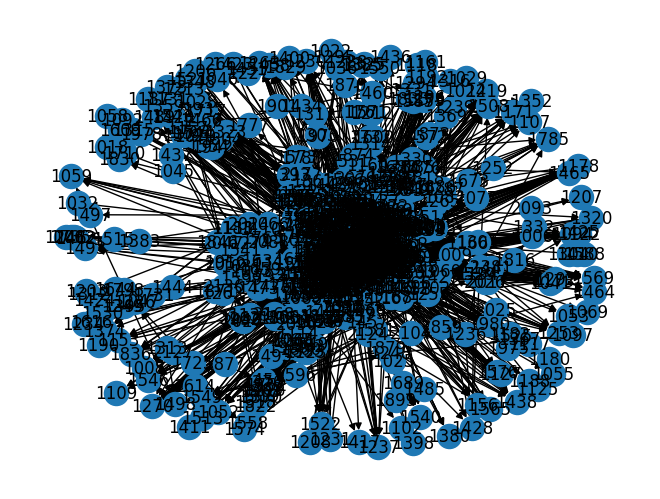

In [17]:
import pandas as pd
import networkx as nx

# Load data from CSV file
df = pd.read_csv('/content/Payments.csv')

# Construct the graph
G = nx.from_pandas_edgelist(df, source='Sender', target='Receiver', edge_attr=True, create_using=nx.DiGraph())

# Featurization
# Example: Node features
for node in G.nodes(data=True):
    node_id = node[0]
    node_attributes = node[1]
    # Extract features from node_attributes and add them to the node

# Example: Edge features
for sender, receiver, attributes in G.edges(data=True):
    sender_id = sender
    receiver_id = receiver
    # Extract features from attributes and add them to the edge

# Example: Graph features
graph_features = {
    'num_nodes': G.number_of_nodes(),
    'num_edges': G.number_of_edges(),
    # Add more graph-level features as needed
}

# Optionally, visualize the graph
nx.draw(G, with_labels=True)
plt.show()


In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class GCNLayer(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(GCNLayer, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, adjacency_matrix, features):
        # Perform graph convolution operation
        output = torch.matmul(adjacency_matrix, features)  # A * X
        output = self.linear(output)  # Apply linear transformation
        output = F.relu(output)  # Apply activation function
        return output

class GCNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCNModel, self).__init__()
        self.gcn_layer1 = GCNLayer(input_dim, hidden_dim)
        self.gcn_layer2 = GCNLayer(hidden_dim, output_dim)

    def forward(self, adjacency_matrix, features):
        # Forward pass through GCN layers
        h1 = self.gcn_layer1(adjacency_matrix, features)
        h2 = self.gcn_layer2(adjacency_matrix, h1)
        return h2


In [22]:
import pandas as pd

# Load data from CSV file
df_payments = pd.read_csv('Payments.csv')

# Explore the data to understand its structure and contents
print(df_payments.head())

# Perform any necessary preprocessing steps, such as cleaning, transforming, or encoding the data

# Once preprocessed, you can use the data to construct the graph and perform featurization for GCN training


   Sender  Receiver  Amount
0    1309      1011  123051
1    1309      1011  118406
2    1309      1011  112456
3    1309      1011  120593
4    1309      1011  166396


In [26]:
import numpy as np
import pandas as pd

# Load the payment data
df = pd.read_csv('Payments.csv')

# Get unique sender and receiver IDs
senders = df['Sender'].unique()
receivers = df['Receiver'].unique()
all_nodes = np.unique(np.concatenate((senders, receivers)))

# Initialize an empty adjacency matrix
num_nodes = len(all_nodes)
adj_matrix = np.zeros((num_nodes, num_nodes))

# Fill the adjacency matrix based on sender-receiver relationships
for _, row in df.iterrows():
    sender_idx = np.where(all_nodes == row['Sender'])[0][0]
    receiver_idx = np.where(all_nodes == row['Receiver'])[0][0]
    adj_matrix[sender_idx, receiver_idx] = 1
    adj_matrix[receiver_idx, sender_idx] = 1  # Assuming transactions are bidirectional

# Extract transaction amounts as features
features = df['Amount'].values

# Define labels (placeholder)
labels = np.zeros(num_nodes)  # Placeholder for labels

# Print the shapes of the defined variables
print("Adjacency Matrix Shape:", adj_matrix.shape)
print("Features Shape:", features.shape)
print("Labels Shape:", labels.shape)


Adjacency Matrix Shape: (799, 799)
Features Shape: (130535,)
Labels Shape: (799,)


In [36]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class GCNLayer(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(GCNLayer, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, adj_matrix, features):
        support = torch.mm(adj_matrix, features)
        output = self.linear(support)
        return F.relu(output)

class GCNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCNModel, self).__init__()
        self.layer1 = GCNLayer(input_dim, hidden_dim)
        self.layer2 = GCNLayer(hidden_dim, output_dim)

    def forward(self, adj_matrix, features):
        h1 = self.layer1(adj_matrix, features)
        h2 = self.layer2(adj_matrix, h1)
        return h2
# Define your adjacency matrix, features, and labels
adj_matrix = torch.zeros((799, 799))  # Assuming a dense adjacency matrix with 799 nodes
features = torch.zeros((799, 1))  # Assuming you have 799 feature vectors (one for each node)
labels = torch.zeros(799, dtype=torch.long)  # Assuming you have labels for each of the 799 nodes

# Define the GCN model
input_dim = features.size(1)  # Get the second dimension of features
hidden_dim = 64
output_dim = 2
model = GCNModel(input_dim, hidden_dim, output_dim)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Train the model
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(adj_matrix, features)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item()}")





Epoch 1, Loss: 0.6415459513664246
Epoch 2, Loss: 0.6345342397689819
Epoch 3, Loss: 0.6298494338989258
Epoch 4, Loss: 0.625190794467926
Epoch 5, Loss: 0.6205586194992065
Epoch 6, Loss: 0.6159533858299255
Epoch 7, Loss: 0.6113749742507935
Epoch 8, Loss: 0.6068242788314819
Epoch 9, Loss: 0.6023014783859253
Epoch 10, Loss: 0.5978068709373474


In [37]:
# Assuming model is already trained
# Extract embeddings from the trained GCN model
def extract_embeddings(model, adj_matrix, features):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient computation
        embeddings = model.layer1(adj_matrix, features)  # Extract embeddings from the first GCN layer
    return embeddings

# Call the function to extract embeddings
embeddings = extract_embeddings(model, adj_matrix, features)
print("Embeddings Shape:", embeddings.shape)


Embeddings Shape: torch.Size([799, 64])


Model has trainable parameters
Epoch 1, Loss: 0.6900144815444946
Epoch 2, Loss: 0.5211142897605896
Epoch 3, Loss: 0.38656580448150635
Epoch 4, Loss: 0.2831210792064667
Epoch 5, Loss: 0.20592068135738373
Epoch 6, Loss: 0.14958231151103973
Epoch 7, Loss: 0.10905873030424118
Epoch 8, Loss: 0.0801171213388443
Epoch 9, Loss: 0.05946921929717064
Epoch 10, Loss: 0.044686250388622284


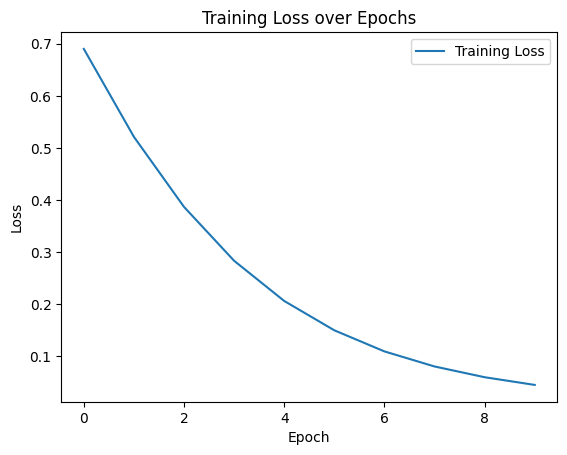

In [43]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Define your GCN model class
class GCNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCNModel, self).__init__()
        # Define your GCN layers
        self.layer1 = nn.Linear(input_dim, hidden_dim)
        self.layer2 = nn.Linear(hidden_dim, output_dim)
        # Define other layers as needed

    def forward(self, adj_matrix, features):
        # Implement the forward pass of your model
        h1 = F.relu(self.layer1(features))
        h2 = self.layer2(h1)
        return h2

# Define your dataset and other necessary components

# Instantiate your GCN model
model = GCNModel(input_dim, hidden_dim, output_dim)

# Check if the model has parameters
if list(model.parameters()):
    print("Model has trainable parameters")
else:
    print("Model does not have trainable parameters")

# Define your loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Train the model
num_epochs = 10
train_losses = []

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(adj_matrix, features)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())
    print(f"Epoch {epoch+1}, Loss: {loss.item()}")

# Plot the training loss
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()
